In [14]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import os
import re
import seaborn as sns


%matplotlib widget

data_path = "data/"
train_lidar_path = data_path + "train_lidar/"
train_labels_path = data_path + "train_infos/"

img_dir = "img/"

classes = {
    "Car": 0,
    "Truck": 1,
    "Bus": 2,
    "Pedestrian": 3,
    "Cyclist": 4
}

# get cmap from matplotlib
cm_viridis = mpl.cm.get_cmap('viridis')
cm_hsv = mpl.cm.get_cmap('hsv')
cm_gp2 = mpl.cm.get_cmap('gnuplot2')
cm_gistrb = mpl.cm.get_cmap('gist_rainbow')
cm_rb = mpl.cm.get_cmap('rainbow')

class_colors = {
    name : color
    for name, color in zip(classes.keys(), cm_rb(np.linspace(0, 1, len(classes))))
}


/tmp/ipykernel_190847/2768919843.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm_viridis = mpl.cm.get_cmap('viridis')
/tmp/ipykernel_190847/2768919843.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm_hsv = mpl.cm.get_cmap('hsv')
/tmp/ipykernel_190847/2768919843.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm_gp2 = mpl.cm.get_cmap('gnuplot2')
/tmp/ipykernel_190847/2768919843.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matp

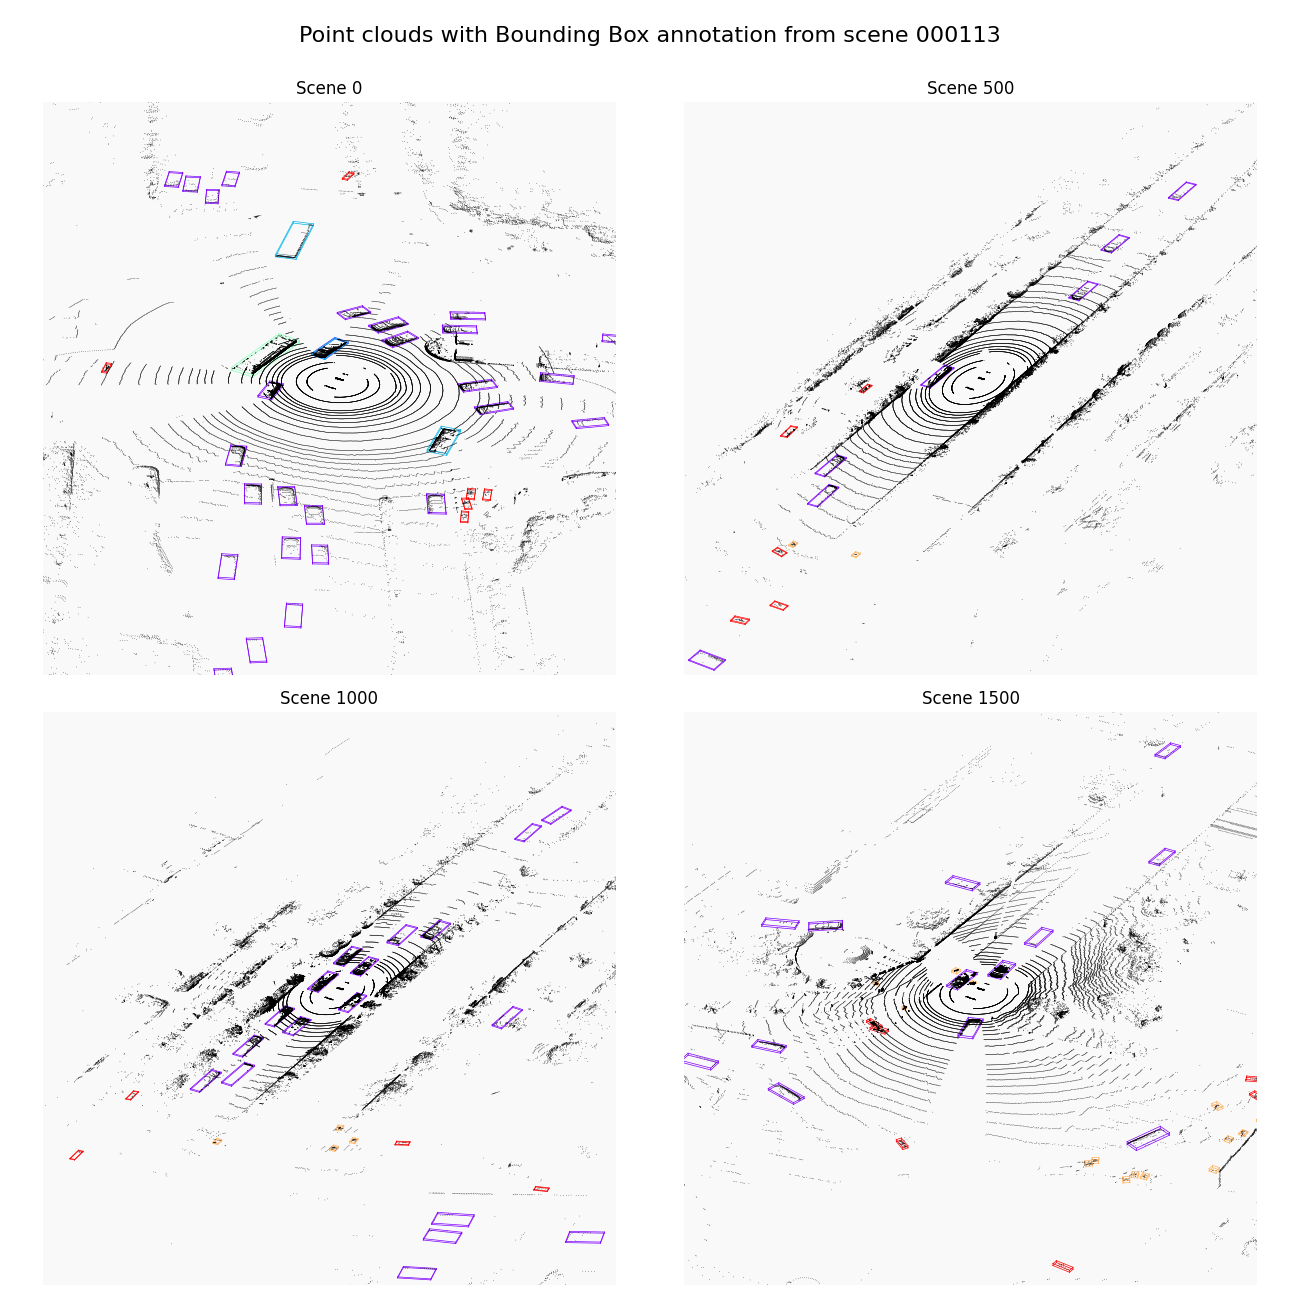

In [15]:
# Read labels from json
scene_set = "000113"
all_scenes_pc = []

scene_nos = list(map(lambda x : x * 250, [0, 2, 4, 6])) # Only even number data points have annotations

# create subplots
fig, axs = plt.subplots(2, 2, subplot_kw={"projection": "3d"}, figsize=(13, 13))

# zoom setup
zoom = 4
lim = (-100 / zoom, 100 / zoom)

# style
face_color = "#f9f9f9"

for scene_no, ax in zip(scene_nos, axs.flatten()):

    # scene_no = 0
    flabels = train_labels_path + f"data/{scene_set}/{scene_set}.json"

    with open(flabels) as f:
        labels = json.load(f)

    # get annotations from first scene
    annotations = labels["frames"][scene_no]["annos"]


    # plot all bounding boxes in the scene
    for name, box in zip(annotations["names"], annotations["boxes_3d"]):
        # center_x, center_y, center_z, l, w, h, yaw

        # find the corners of the box
        center_x, center_y, center_z, l, w, h, yaw = box

        corners_x = np.array([[l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2]]).T
        corners_y = np.array([[w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]]).T
        corners_z = np.array([[h/2, h/2, h/2, h/2, -h/2, -h/2, -h/2, -h/2]]).T
        points = np.hstack((corners_x, corners_y, corners_z))

        # rotation matrix
        R = np.array([[np.cos(-yaw), -np.sin(-yaw), 0],
                      [np.sin(-yaw),  np.cos(-yaw), 0],
                      [           0,             0, 1]])
        # rotate the box
        points = points @ R

        # offset the box with center position
        points[:, 0] += center_x
        points[:, 1] += center_y
        points[:, 2] += center_z

        # colors
        line_c = class_colors[name]
        line_a = 1
        line_w = 0.5

        # plot 12 lines of bounding box
        for i in range(4):
            ax.plot3D(points[[i, i+4], 0], points[[i, i+4], 1], points[[i, i+4], 2], c=line_c, alpha=line_a, linewidth=line_w)
        for i in range(4):
            ax.plot3D(points[[i, (i+1)%4], 0], points[[i, (i+1)%4], 1], points[[i, (i+1)%4], 2], c=line_c, alpha=line_a, linewidth=line_w)
        for i in range(4):
            ax.plot3D(points[[i+4, (i+1)%4+4], 0], points[[i+4, (i+1)%4+4], 1], points[[i+4, (i+1)%4+4], 2], c=line_c, alpha=line_a, linewidth=line_w)


    # read point cloud
    scene_dir = train_lidar_path + f"data/{scene_set}/lidar_roof/"
    all_scenes_pc = [f.path for f in os.scandir(scene_dir) if f.is_file()]
    all_scenes_pc.sort(key = lambda x : int(re.sub("\D", "", x)))

    point_cloud = np.fromfile(all_scenes_pc[scene_no], dtype=np.float32).reshape(-1, 4)

    # plot the point cloud in 3D
    ax.scatter3D(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=0.2, edgecolors="none", c="black", alpha=1)

    # plot setup
    ax.set_aspect("equal", adjustable="box")
    ax.set_title(f"Scene {scene_no}")

    # zooming
    ax.set_xlim3d(lim[0], lim[1])
    ax.set_ylim3d(lim[0], lim[1])
    ax.set_zlim3d(lim[0], lim[1])
    ax.set_axis_off()

    ax.set_facecolor(face_color)

# fig.tight_layout(pad=2)
fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle(f"Point clouds with Bounding Box annotation from scene {scene_set}", fontsize=16)

# save as png and pdf
fig.savefig(img_dir + f"png/point_clouds_{scene_set}.png", dpi=300)
fig.savefig(img_dir + f"pdf/point_clouds_{scene_set}.pdf")

plt.show()

In [16]:
#make the dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision


class ObjectDetectionDataset(Dataset):
    def __init__(self, point_cloud_data, annotations):
        self.point_cloud_data = point_cloud_data
        self.annotations = annotations
        
    def __len__(self):
        return len(self.point_cloud_data)

    def __getitem__(self, idx):
        #return data point cloud scene and targets (bounding boxes)
        return torch.Tensor(self.point_cloud_data[idx]), torch.Tensor(self.annotations[idx])

targets = []
target = []

for scene_no in (scene_nos):
    label = labels["frames"][scene_no]["annos"]
    for name, box in zip(label["names"], label["boxes_3d"]):
        bb = np.array(np.append(classes[name], box))
        target.append(bb)
    targets.append(np.array(target))


point_clouds = []
for scene in all_scenes_pc:
    point_clouds.append(np.array(np.fromfile(scene, dtype=np.float32).reshape(-1, 4)[:, 0:3]))
    
dataset = ObjectDetectionDataset(point_clouds, targets)


dataset[2][1].shape
torch.__version__

'1.13.1'

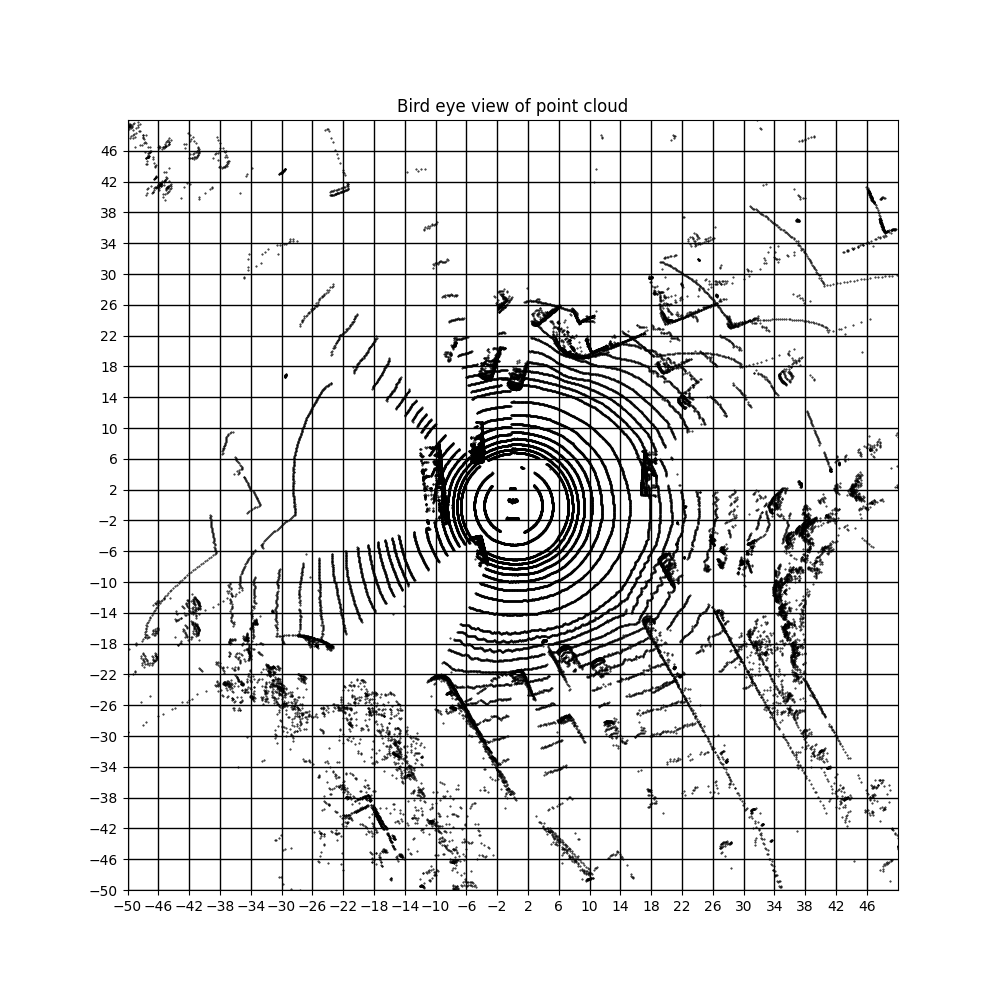

In [17]:
# plot grid on top of point cloud

def plot_grid(point_cloud, ax, title, xlim3d, ylim3d, zlim3d, face_color="white", edgecolors="black", s=0.2, alpha=1):
    # plot the point cloud in 3D
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], s=s, edgecolors=edgecolors, c="black", alpha=alpha)

    # plot setup
    ax.set_aspect("equal", adjustable="box")
    ax.set_title(title)

    # zooming
    ax.set_xlim(xlim3d[0], xlim3d[1])
    ax.set_ylim(ylim3d[0], ylim3d[1])
    # ax.set_axis_off()

    ax.set_facecolor(face_color)

    # plot grid
    ax.grid(True, which="both", axis="both", color="black", linestyle="-", linewidth=1)

    # change grid space
    ax.set_xticks(np.arange(xlim3d[0], xlim3d[1], 4))
    ax.set_yticks(np.arange(ylim3d[0], ylim3d[1], 4))


# plot bird eye view of point cloud
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

plot_grid(dataset[2][0], ax, "Bird eye view of point cloud", [-50, 50], [-50, 50], [-50, 50])

plt.show()



In [23]:
from pcdet.models.detectors.pv_rcnn import PVRCNN

model = PVRCNN(torch.load("models/pv_rcnn_8369.pth"), 5)

model.eval()

# use model on point cloud
with torch.no_grad():
    pred = model(dataset[2][0].unsqueeze(0).unsqueeze(0))





AttributeError: 'list' object has no attribute 'class_names'